In [3]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama as scr
import pandas as pd
from harmony import harmonize
from sklearn.metrics.cluster import adjusted_rand_score
import random
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings('ignore')

from matplotlib.colors import ListedColormap
import seaborn as sn

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=50)

scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


def DE(adata, obs_id, obs_id_test, ref):

    sc.tl.rank_genes_groups(adata, groupby=obs_id, groups=[obs_id_test], 
                            reference=ref, method='wilcoxon', n_genes=200)

    wilcLF = adata.uns['rank_genes_groups']['logfoldchanges'].astype([(obs_id_test, '<f8')]).view('<f8') #log fold changes ordered by score

    wilcGenes_s = list(adata.uns['rank_genes_groups']['names'].astype([(obs_id_test, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
    wilcLF_s = adata.uns['rank_genes_groups']['logfoldchanges'].astype([(obs_id_test, '<f8')]).view('<f8') #numpy array of logfoldchnages to be ordered lowest to highest
    wilcLF_s.sort() #log fold changes from lowest to highest
    wilcGenes = [] #list of genes ordered by logfold change: low to high

    for i in wilcLF_s:
        gene_idx = np.where(wilcLF == i)[0][0]
        wilcGenes.append(wilcGenes_s[gene_idx])

    wilcGenes_correct = []
    for i in reversed(wilcGenes):
        wilcGenes_correct.append(i) # #list of genes ordered by logfold change high to low
        
    return wilcGenes_correct, pd.Series(wilcLF_s).sort_values(ascending=False).values

In [1]:
def DE(adata, obs_id, obs_id_test, ref):

    sc.tl.rank_genes_groups(adata, groupby=obs_id, groups=[obs_id_test], 
                                reference=ref, method='wilcoxon', pts=True)

    lfcs = adata.uns['rank_genes_groups']['logfoldchanges'].astype([(obs_id_test, '<f8')]).view('<f8') 

    l231_genes = adata.uns['rank_genes_groups']['pts']

    lfcs = []
    names = list(adata.uns['rank_genes_groups']['names'].astype([(obs_id_test, '<U50')]).view('<U50'))
    logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'].astype([(obs_id_test, '<f8')]).view('<f8')
    for i in l231_genes.index:
        lfcs.append(logfoldchanges[names.index(i)])

    l231_genes['LF'] = lfcs

    #plt.hist(l231_genes[obs_id_test].values)

    l231_genes = l231_genes[l231_genes[obs_id_test]>0.2]

    return pd.Series(l231_genes['LF']).sort_values(ascending=False)

In [ ]:
L23

# Clustering

In [7]:
P28_glut = sc.read_h5ad('P28_dr_glut.h5ad')

In [9]:
P28_glut

AnnData object with n_obs × n_vars = 24430 × 20350
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample'
    var: 'gene_ids', 'feature_types', 'n_cells-P28_dr_1a', 'n_cells-P28_dr_1b', 'n_cells-P28_dr_3a', 'n_cells-P28_dr_3b', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'leiden_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap'

Off on the wrong foot with C0 and C5; remove them.

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


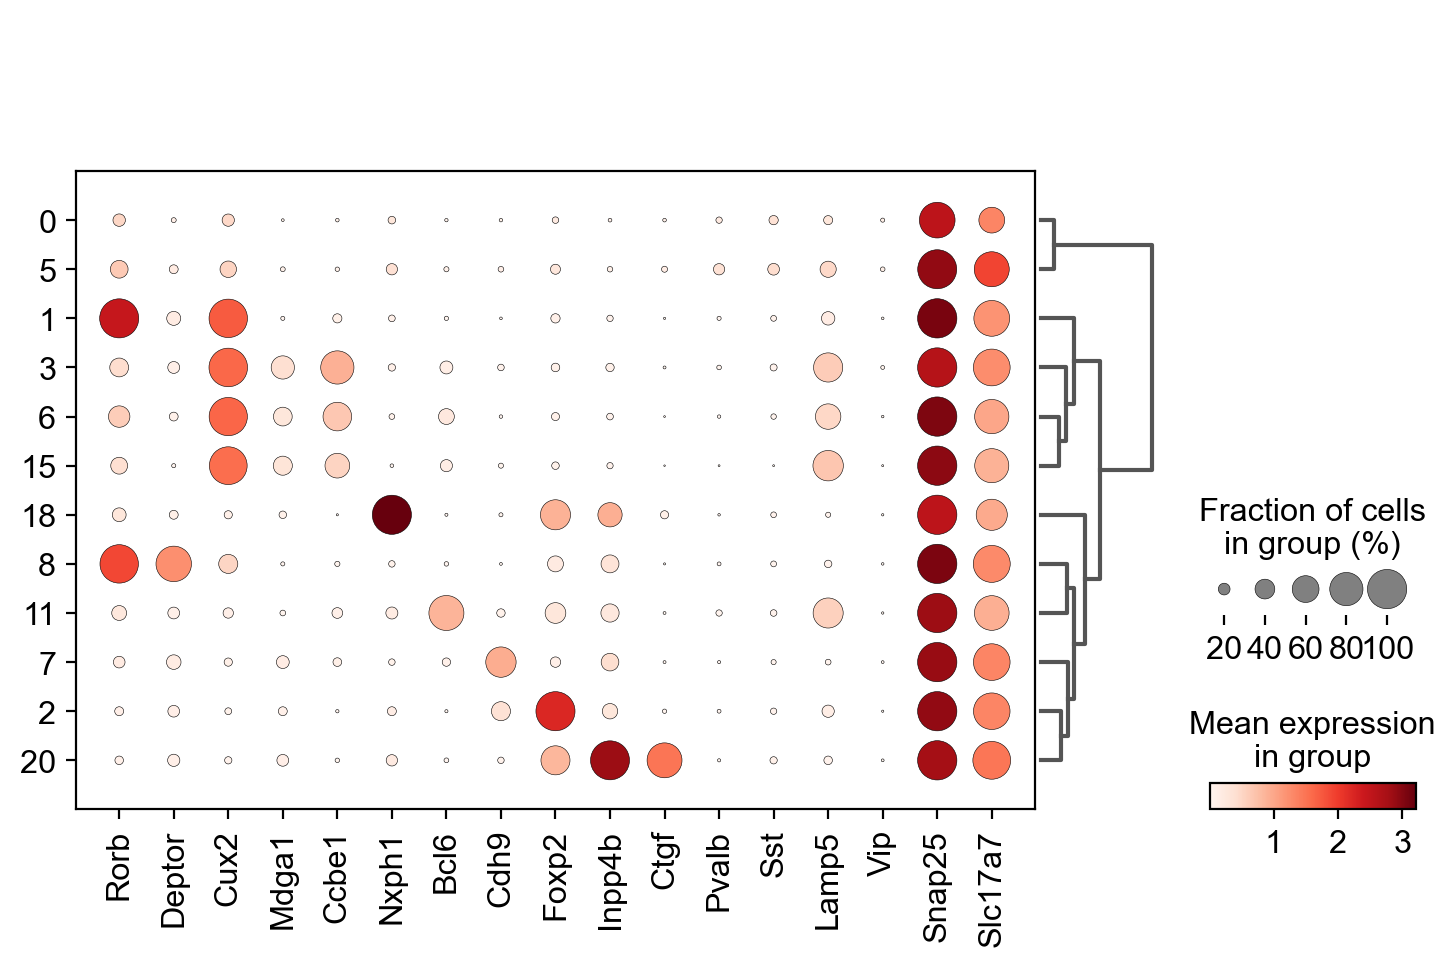

In [12]:
sc.pl.dotplot(P28_glut, ['Rorb', 'Deptor', 'Cux2', 'Mdga1', 'Ccbe1', 'Nxph1', 'Bcl6',
                'Cdh9', 'Foxp2', 'Inpp4b', 'Ctgf', 'Pvalb', 'Sst', 'Lamp5', 'Vip', 'Snap25', 'Slc17a7'], 
              groupby='leiden', dendrogram=True)

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


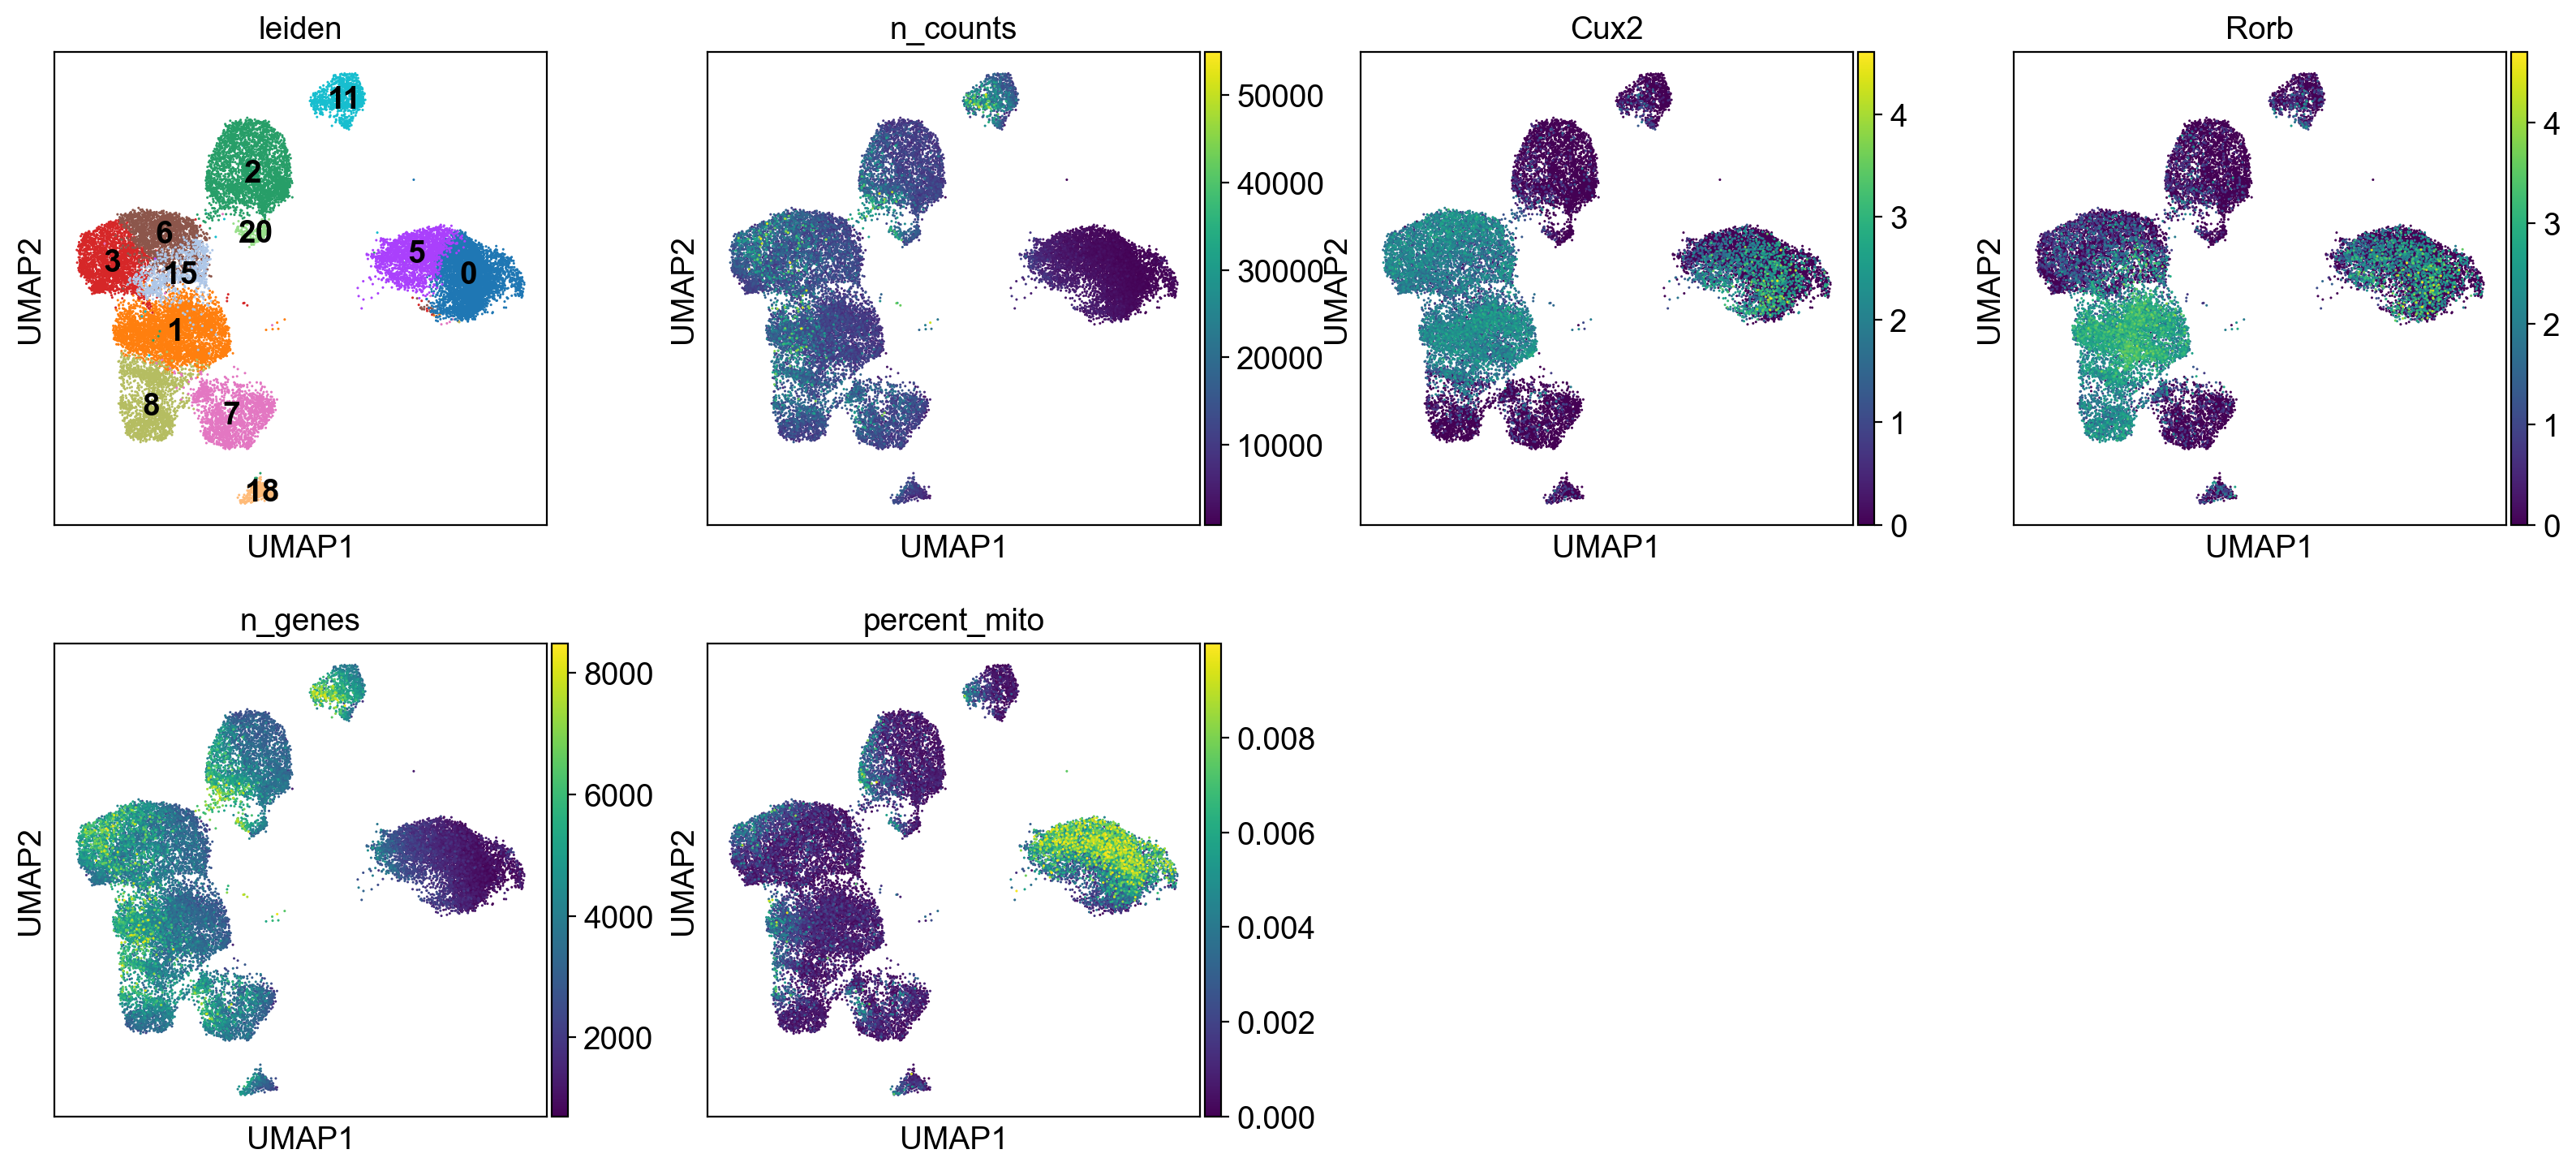

In [14]:
sc.pl.umap(P28_glut, color=['leiden', 'n_counts', 'Cux2', 'Rorb', 
                            'n_genes', 'percent_mito'], legend_loc='on data')

In [15]:
P28_glut = P28_glut[P28_glut.obs['leiden']!='0',:]
P28_glut = P28_glut[P28_glut.obs['leiden']!='5',:]

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [16]:
P28_glut

View of AnnData object with n_obs × n_vars = 17399 × 20350
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample'
    var: 'gene_ids', 'feature_types', 'n_cells-P28_dr_1a', 'n_cells-P28_dr_1b', 'n_cells-P28_dr_3a', 'n_cells-P28_dr_3b', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'leiden_colors', 'sample_colors', "dendrogram_['leiden']"
    obsm: 'X_pca', 'X_umap'

In [31]:
P28_glut #after discarding from first clustering run

View of AnnData object with n_obs × n_vars = 16408 × 20350
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors', "dendrogram_['leiden']"
    obsm: 'X_pca', 'X_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [3]:
P28_glut = sc.read_h5ad('P28_glut_dr_harmony_120120.h5ad')

In [6]:
del P28_glut.obsp
del P28_glut.varm
del P28_glut.obsm
del P28_glut.uns
#for i in ['n_cells-P28_dr_1a', 'n_cells-P28_dr_1b', 'n_cells-P28_dr_3a', 
#          'n_cells-P28_dr_3b', 'highly_variable', 'means', 'dispersions', 
#          'dispersions_norm', 'mean', 'std']: del P28_glut.var[i]
P28_glut

AnnData object with n_obs × n_vars = 16379 × 20350
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'layer', 'cluster', 'Type'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'

In [7]:
P28_glut.X = P28_glut.raw.X.A
sc.pp.highly_variable_genes(P28_glut, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs

sc.pp.scale(P28_glut, max_value=10) #scale
sc.tl.pca(P28_glut, svd_solver='arpack') #run PCA

Z = harmonize(P28_glut.obsm['X_pca'], P28_glut.obs, batch_key = 'sample')
P28_glut.obsm['X_harmony'] = Z

sc.pp.neighbors(P28_glut, n_neighbors=25, use_rep='X_harmony')

#sc.pp.neighbors(P28_glut, n_neighbors=25)
#bbknn(P28_glut, batch_key='sample',neighbors_within_batch =6 ) #doesn't work
#sc.tl.leiden(P28_glut)
sc.tl.umap(P28_glut)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
computing neighbors


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../op

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


P28_glut = P28_glut[P28_glut.obs['leiden']!='21',:]
P28_glut = P28_glut[P28_glut.obs['leiden']!='19',:]
P28_glut = P28_glut[P28_glut.obs['leiden']!='13',:]
P28_glut = P28_glut[P28_glut.obs['leiden']!='15',:]
P28_glut = P28_glut[P28_glut.obs['leiden']!='17',:]
P28_glut = P28_glut[P28_glut.obs['leiden']!='20',:]

Read after kernel dies

First plot at left is correct. Right most plot is old wrong clustering

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


<AxesSubplot:title={'center':'P28 DR: 16379 cells'}, xlabel='UMAP1', ylabel='UMAP2'>

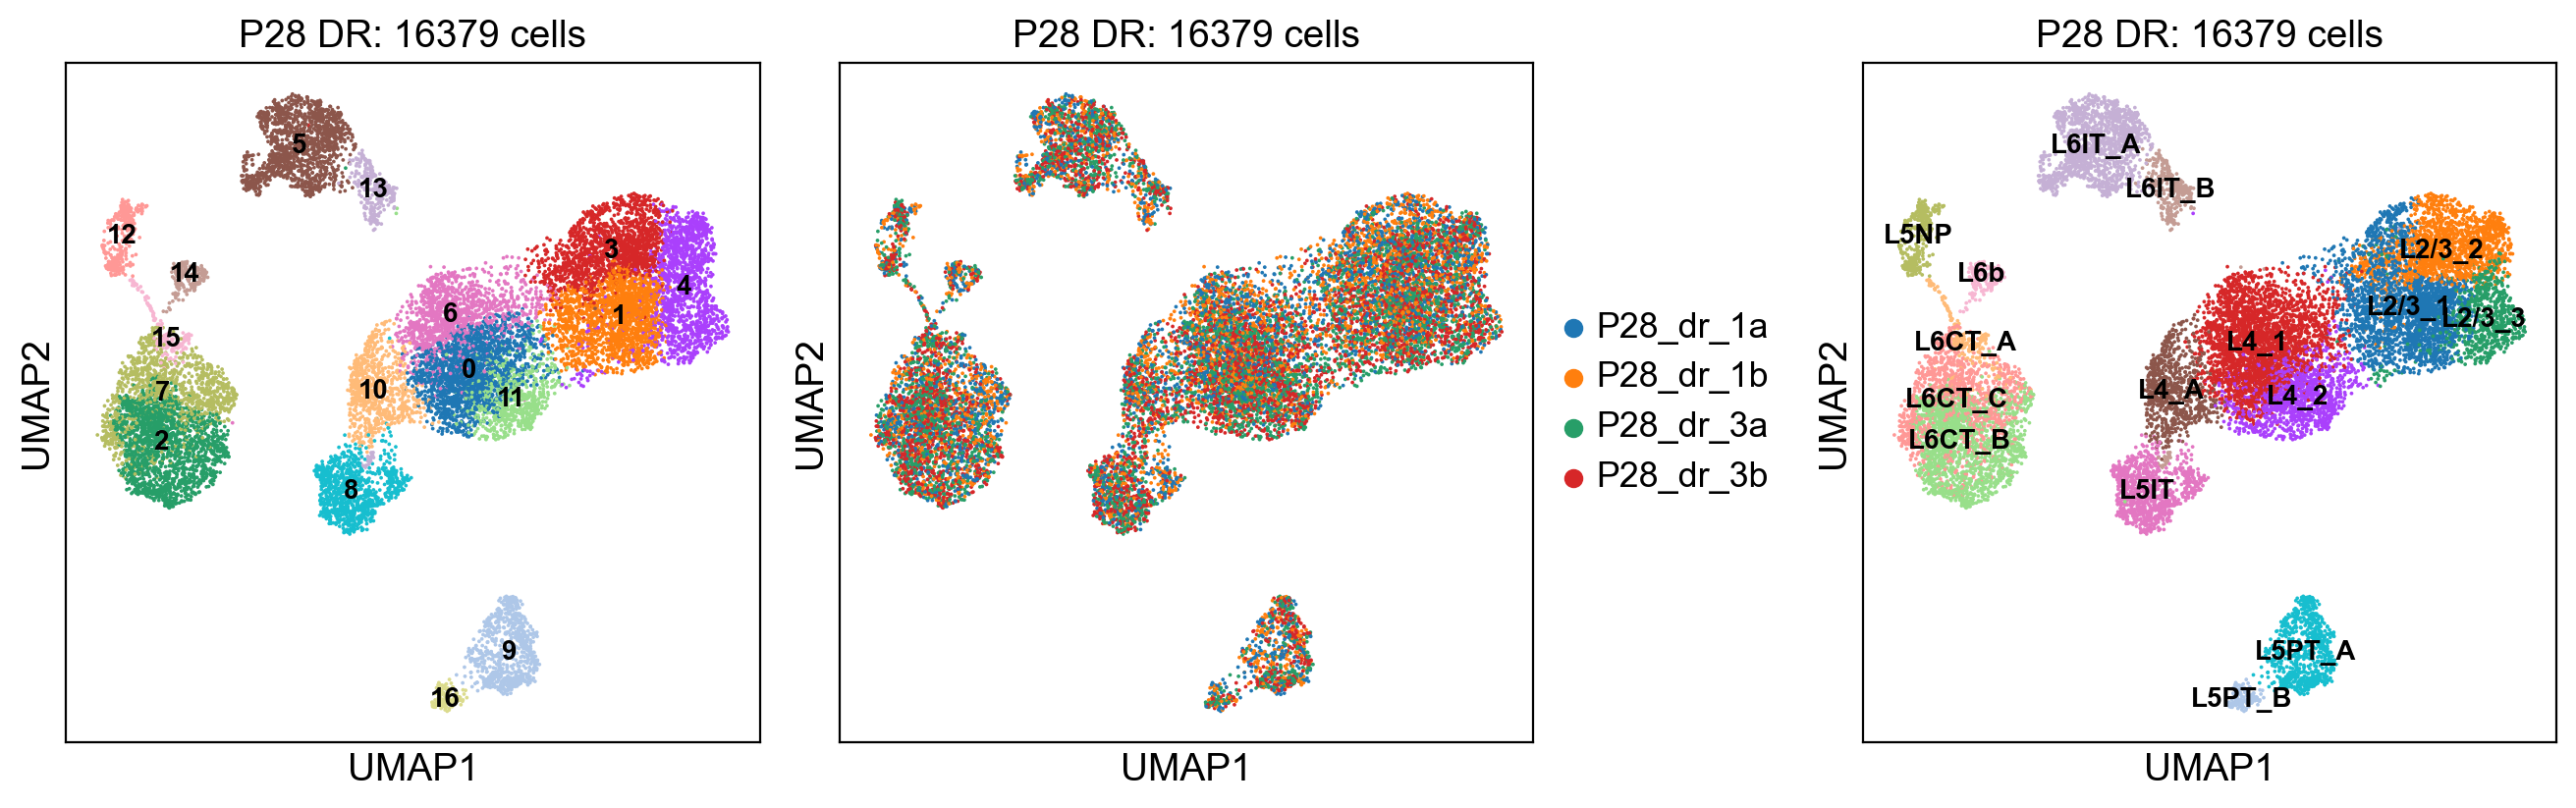

In [27]:
sc.tl.leiden(P28_glut,)
fig, axs = plt.subplots(1, 3, figsize = (13,4), constrained_layout=True)
sc.pl.umap(shuffle(P28_glut), color='leiden', legend_fontsize='10', ax=axs[0], 
           show=False, title='P28 DR: ' + str(P28_glut.shape[0]) + ' cells', frameon=True, legend_loc='on data')

sc.pl.umap(shuffle(P28_glut), color='sample', ax=axs[1], show=False, title='P28 DR: ' + str(P28_glut.shape[0]) + ' cells')
sc.pl.umap(P28_glut, color='Type', ax=axs[2], show=False, title='P28 DR: ' + str(P28_glut.shape[0]) + ' cells', 
           legend_loc='on data', legend_fontsize=10)

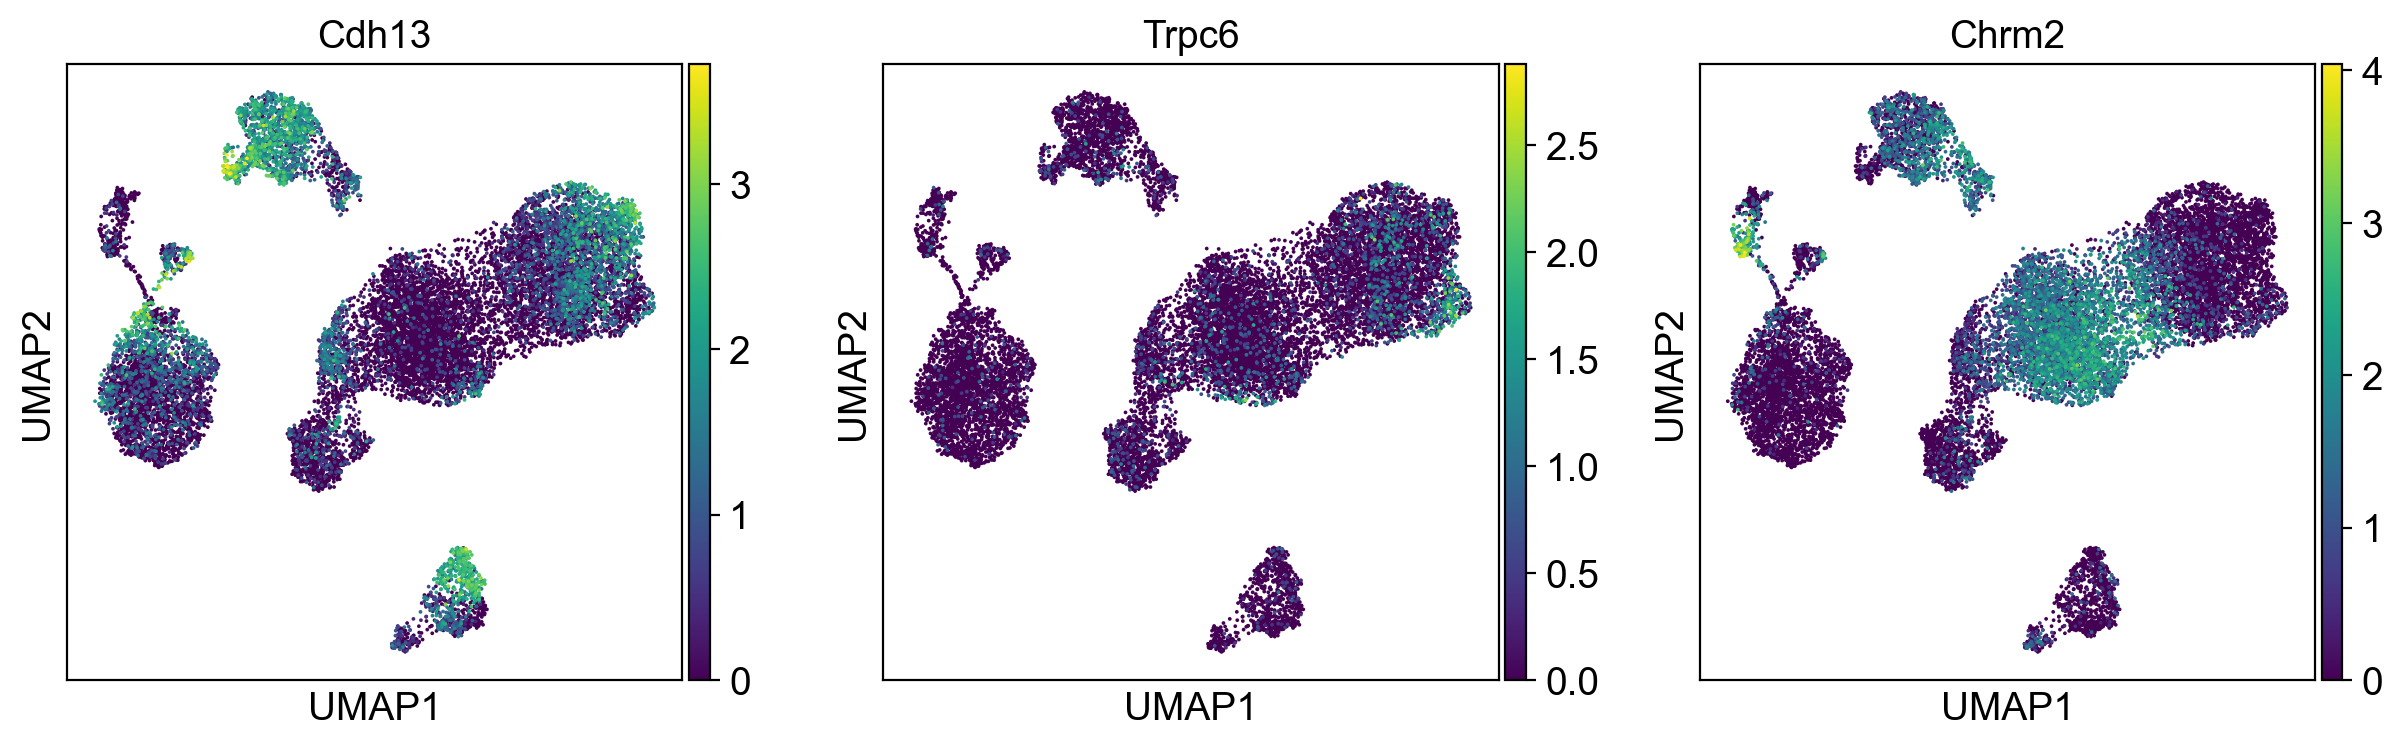

In [24]:
sc.pl.umap(P28_glut, color=['Cdh13', 'Trpc6', 'Chrm2'])

Storing dendrogram info using `.uns["dendrogram_['leiden']"]`


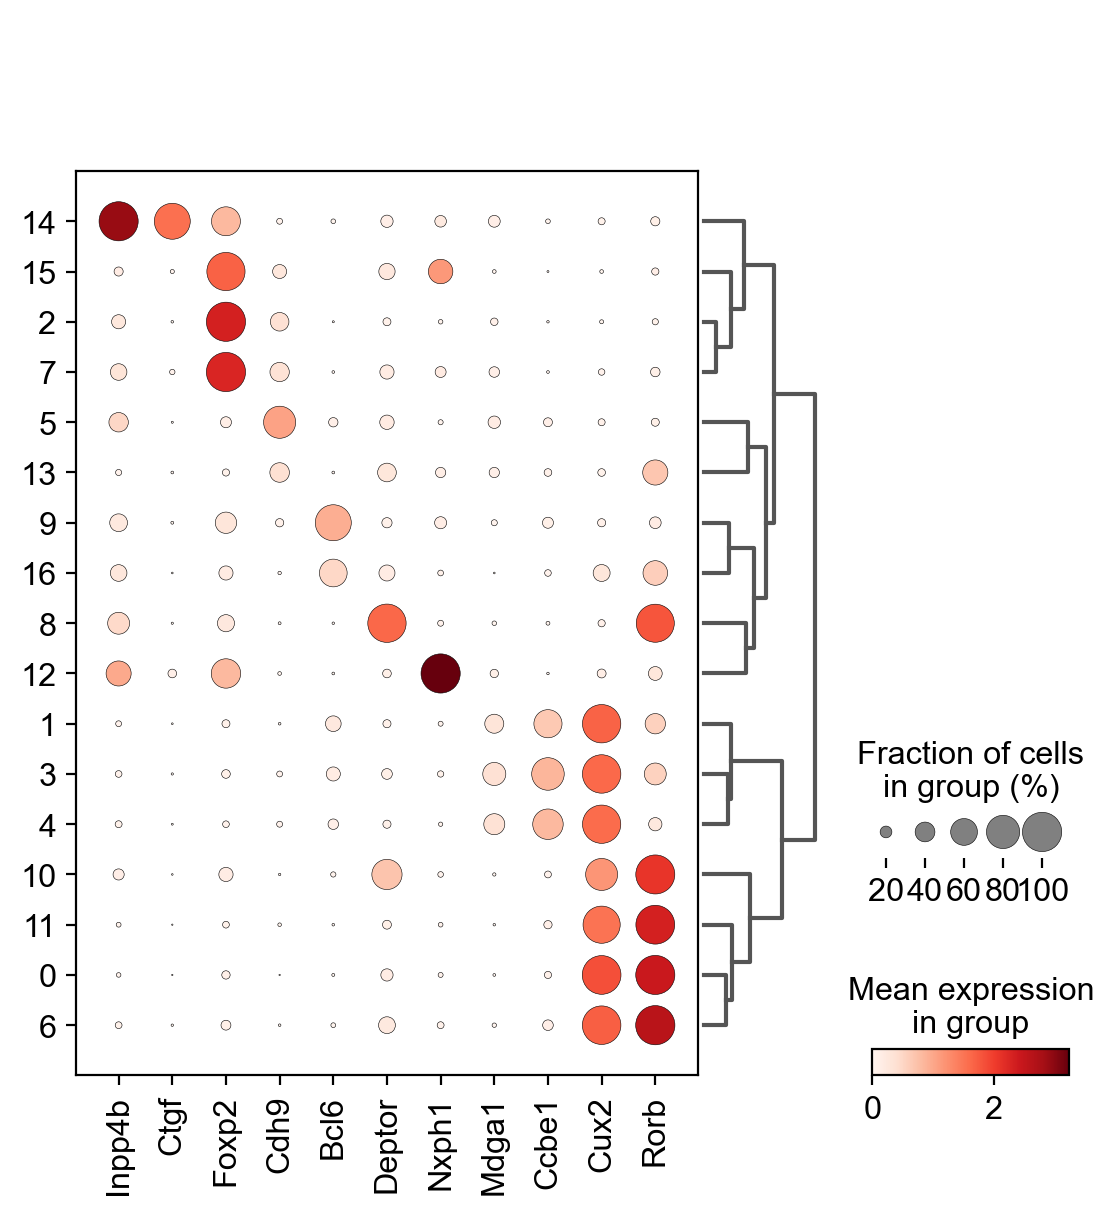

In [28]:
sc.tl.dendrogram(P28_glut, groupby='leiden', use_rep='X_harmony')

bias_markers = ['Inpp4b', 'Ctgf', 'Foxp2', 'Cdh9', 'Bcl6', 'Deptor',
                 'Nxph1',  'Mdga1', 'Ccbe1', 'Cux2', 'Rorb',]

sc.pl.dotplot(P28_glut, bias_markers, groupby='leiden', dendrogram=True)

## Merge and name clusters


Merge 6 and 0

In [34]:
leidens = []

for i in range(P28_glut.shape[0]):
    leiden = P28_glut.obs.leiden[i]
    if (leiden in ('0','6')):
        leidens.append('L4_1')
    else: leidens.append(leiden)

In [37]:
P28_glut.obs['leiden'] = pd.Categorical(leidens)

In [39]:
P28_glut.obs.leiden.values.categories

Index(['1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '7',
       '8', '9', 'L4_1'],
      dtype='object')

In [6]:
cluster = ['L2/3_3', 'L4_C', 'L4_2', 'L5NP', 'L6IT_B', 'L6b', 
           'L6CT_A', 'L5PT_B', 'L6CT_B', 'L2/3_2', 'L2/3_1', 'L6IT_A', 'L6CT_C',
       'L5IT', 'L5PT_A', 'L4_1']

P28_glut.obs['Type'] = P28_glut.obs['leiden']
a = P28_glut.obs['Type']
P28_glut.obs['Type'] = a.cat.rename_categories(cluster).values

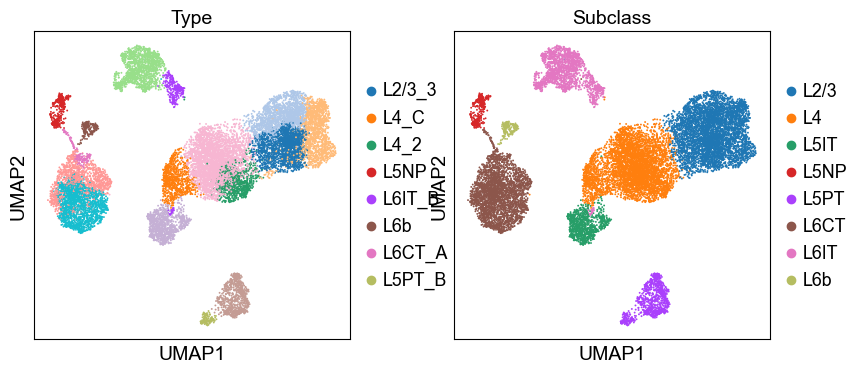

In [7]:
sc.pl.umap(P28_glut, color=['Type', 'Subclass'])

In [45]:
P28_glut.obs['Subclass'] = P28_glut.obs['Type']
P28_glut.obs['Subclass'] = P28_glut.obs['Subclass'].str.replace('_1','')
P28_glut.obs['Subclass'] = P28_glut.obs['Subclass'].str.replace('_2','')
P28_glut.obs['Subclass'] = P28_glut.obs['Subclass'].str.replace('_3','')
P28_glut.obs['Subclass'] = P28_glut.obs['Subclass'].str.replace('_A','')
P28_glut.obs['Subclass'] = P28_glut.obs['Subclass'].str.replace('_AB','')
P28_glut.obs['Subclass'] = P28_glut.obs['Subclass'].str.replace('_B','')
P28_glut.obs['Subclass'] = P28_glut.obs['Subclass'].str.replace('B','')
P28_glut.obs['Subclass'] = P28_glut.obs['Subclass'].str.replace('_C','')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


<AxesSubplot:title={'center':'P28 DR: 16379 cells'}, xlabel='UMAP1', ylabel='UMAP2'>

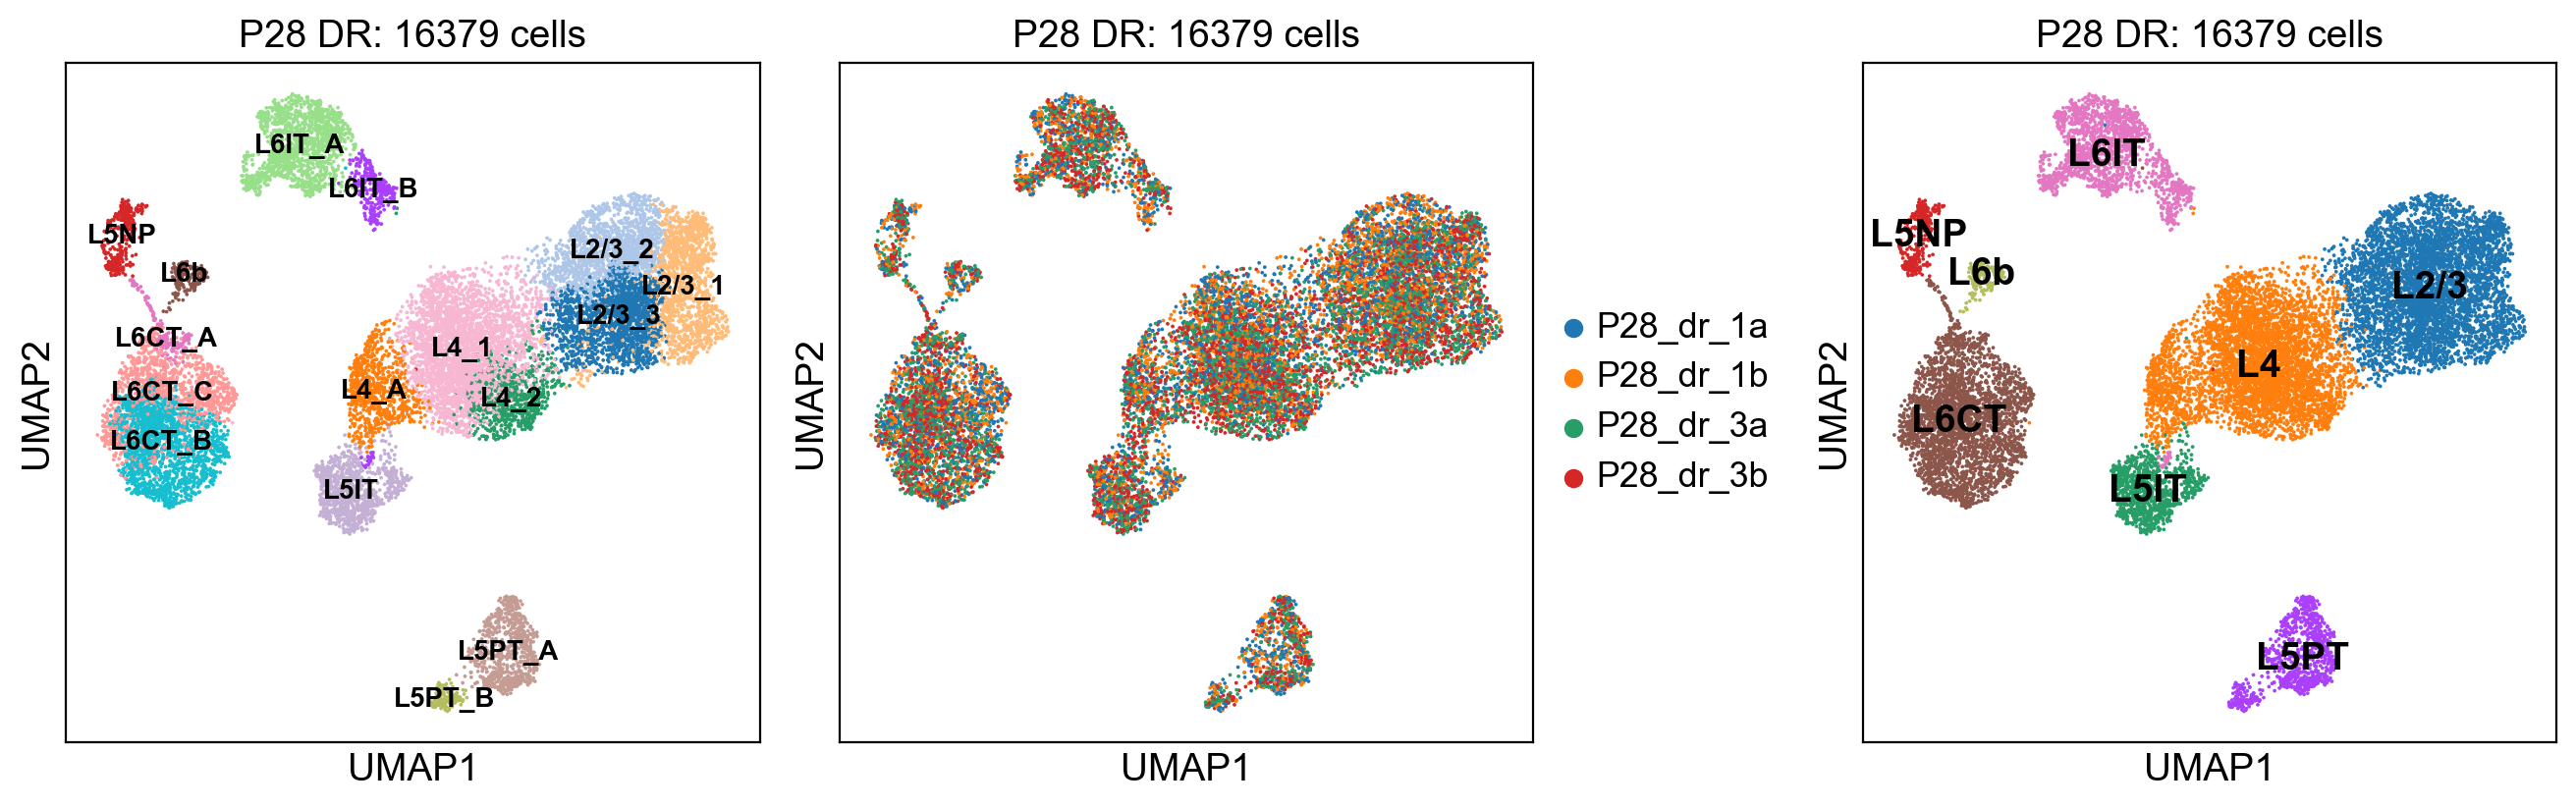

In [79]:
fig, axs = plt.subplots(1, 3, figsize = (13,4), constrained_layout=True)
sc.pl.umap(shuffle(P28_glut), color='Type', legend_fontsize='10', ax=axs[0], 
           show=False, title='P28 DR: ' + str(P28_glut.shape[0]) + ' cells', frameon=True, legend_loc='on data')
sc.pl.umap(shuffle(P28_glut), color='sample', ax=axs[1], show=False, title='P28 DR: ' + str(P28_glut.shape[0]) + ' cells')
sc.pl.umap(shuffle(P28_glut), color='Subclass', ax=axs[2], show=False, 
           title='P28 DR: ' + str(P28_glut.shape[0]) + ' cells', legend_loc='on data')



In [ ]:
#code
to_ids = '/Volumes/GoogleDrive/.shortcut-targets-by-id/1QGxZoHVFYT0iH2PZKwk8j8Z_MzEI00IP/shekharlab_data/projects/MVC/DL&DR/P28/gluta_mapping/'
C1_to_L6CT_A = pd.read_csv(to_ids + 'P28_DR_C1_to_P28_NR_C13.csv')['cell_id'].values
C1_to_L6CT_B = pd.read_csv(to_ids + 'P28_DR_C1_to_P28_NR_C2.csv')['cell_id'].values
C1_to_L6CT_C = pd.read_csv(to_ids + 'P28_DR_C1_to_P28_NR_C6.csv')['cell_id'].values

C7_to_L6CT_B = pd.read_csv(to_ids + 'P28_DR_C7_to_P28_NR_C2.csv')['cell_id'].values
C7_to_L6CT_C = pd.read_csv(to_ids + 'P28_DR_C7_to_P28_NR_C6.csv')['cell_id'].values

In [ ]:
#code
Type = []

for i in range(P28_glut.shape[0]):
    if (P28_glut.obs['cluster'][i] in ['0', '12']): 
        Type.append('L2/3_1') 
    
    elif (P28_glut.obs['cluster'][i] in ['3', '5']): 
        Type.append('L4_1') 
    
    elif (P28_glut.obs.index[i] in C1_to_L6CT_A): 
        Type.append('L6CT_A')
        
    elif (P28_glut.obs.index[i] in C1_to_L6CT_B): 
        Type.append('L6CT_B')
    
    elif (P28_glut.obs.index[i] in C1_to_L6CT_C): 
        Type.append('L6CT_C')
        
    elif (P28_glut.obs.index[i] in C7_to_L6CT_B): 
        Type.append('L6CT_B')
    
    elif (P28_glut.obs.index[i] in C7_to_L6CT_C): 
        Type.append('L6CT_C')
    
    else: Type.append(P28_glut.obs['cluster'][i])

In [ ]:
#code
P28_glut.obs['Type'] = P28_glut.obs['leiden']
P28_glut.obs['Type'] = pd.Series(Type, dtype='category').values
print(P28_glut[P28_glut.obs['Type']=='7_L6CT_BC',:].shape, 
      P28_glut[P28_glut.obs['Type']=='1_L6CT_BC',:].shape)

P28_glut = P28_glut[P28_glut.obs['Type']!='1_L6CT_BC',:]
P28_glut = P28_glut[P28_glut.obs['Type']!='7_L6CT_BC',:]

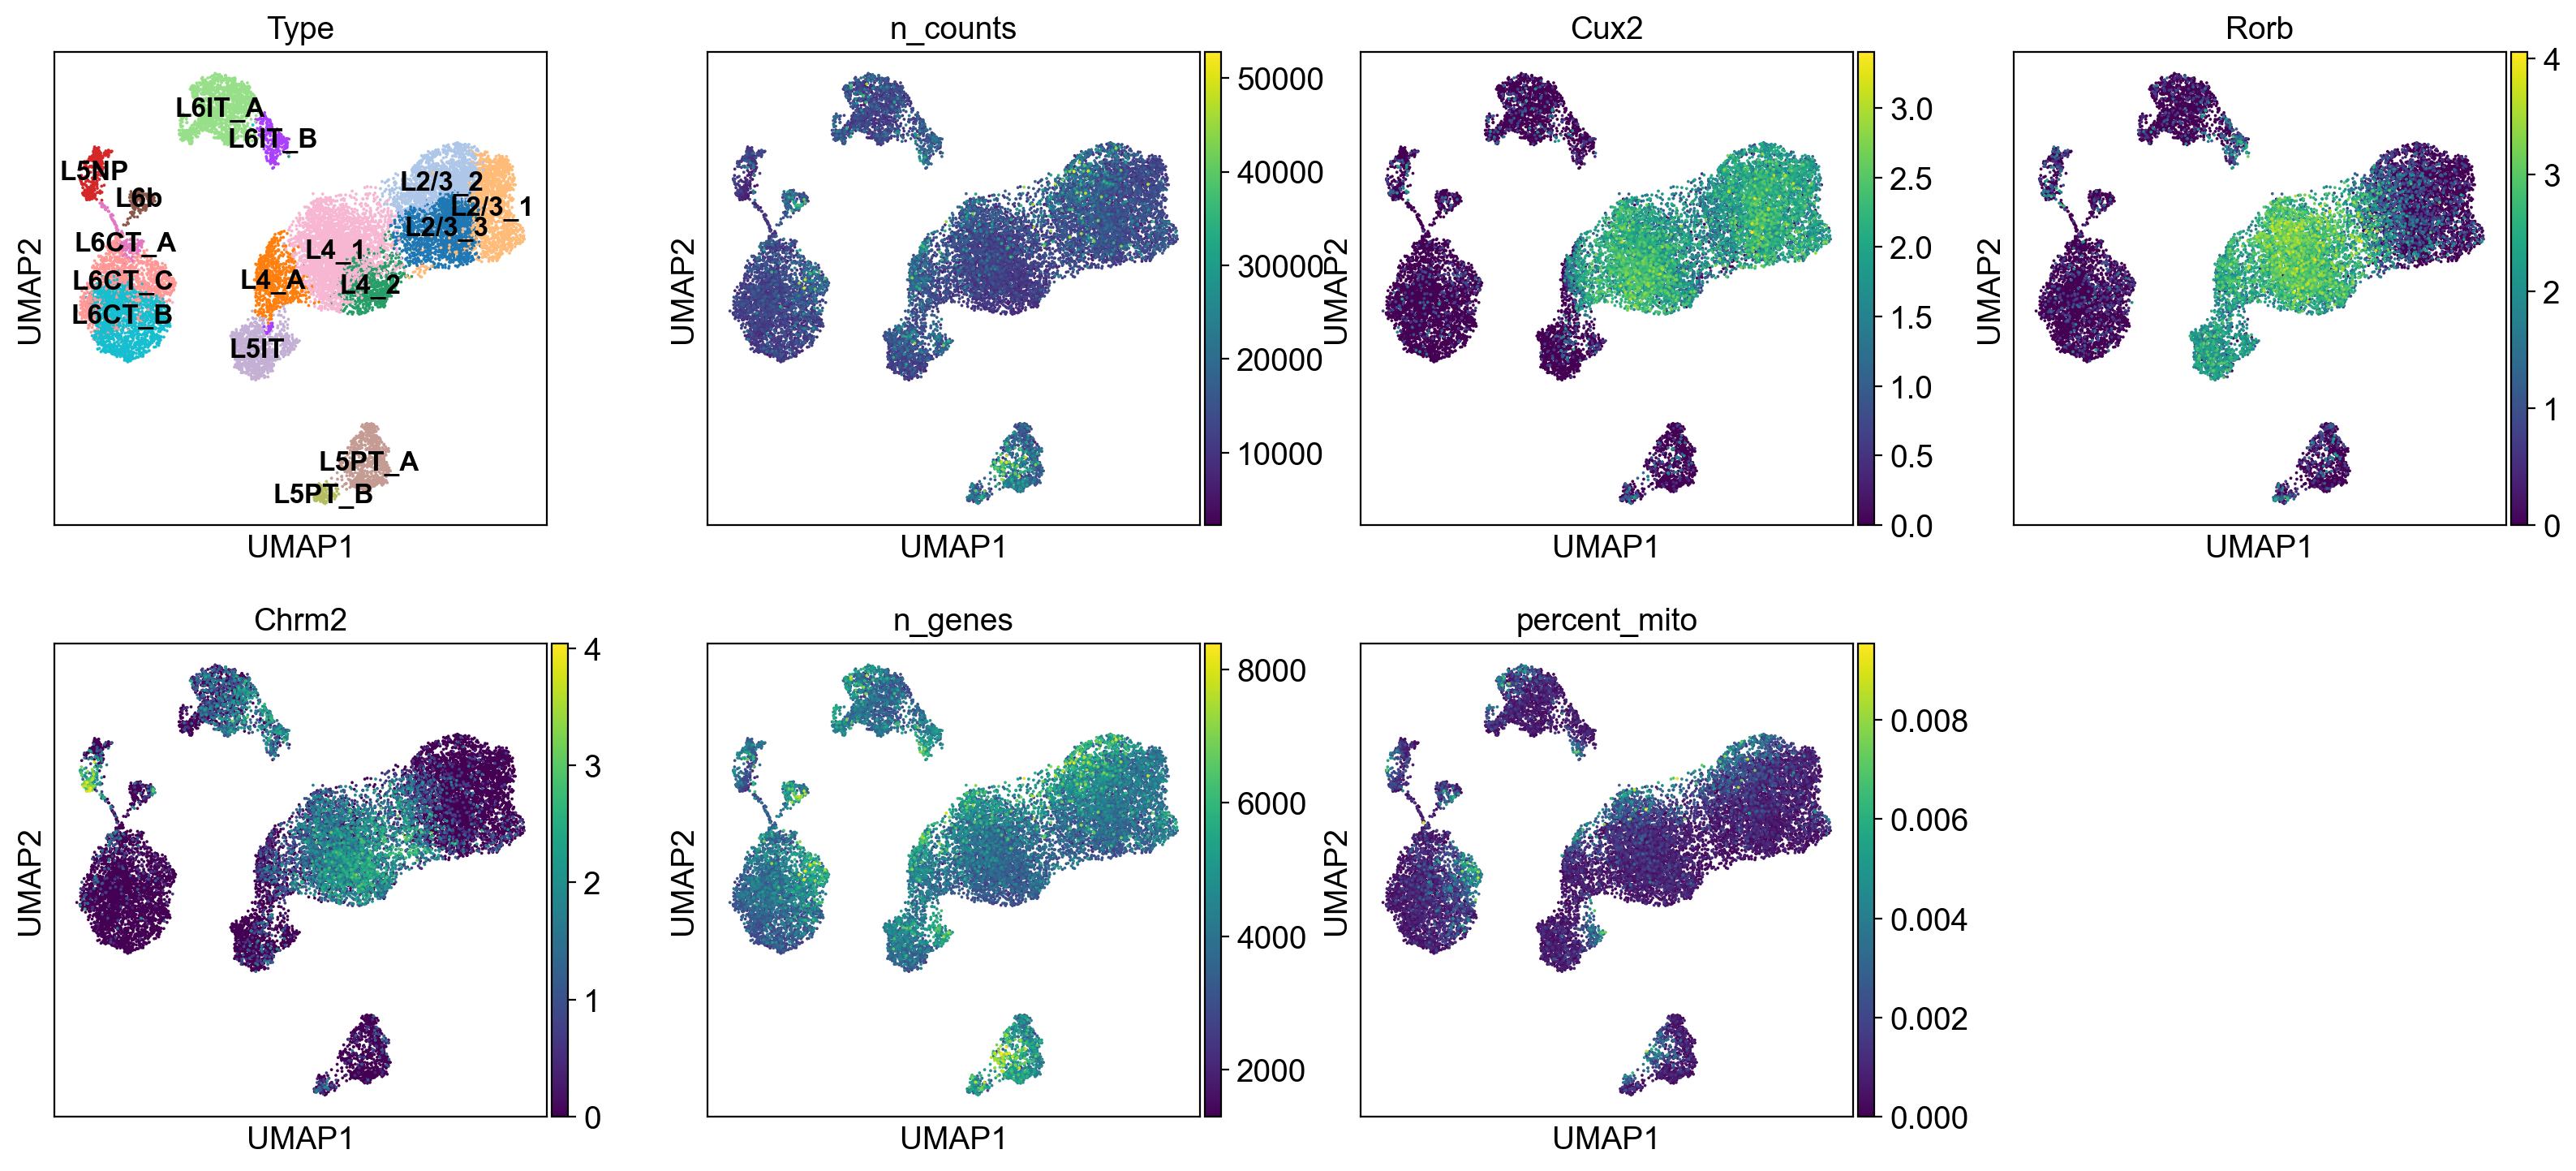

In [44]:
sc.pl.umap(P28_glut, color=['Type', 'n_counts', 'Cux2', 'Rorb', 'Chrm2',
                            'n_genes', 'percent_mito'], legend_loc='on data', legend_fontsize='12',)

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


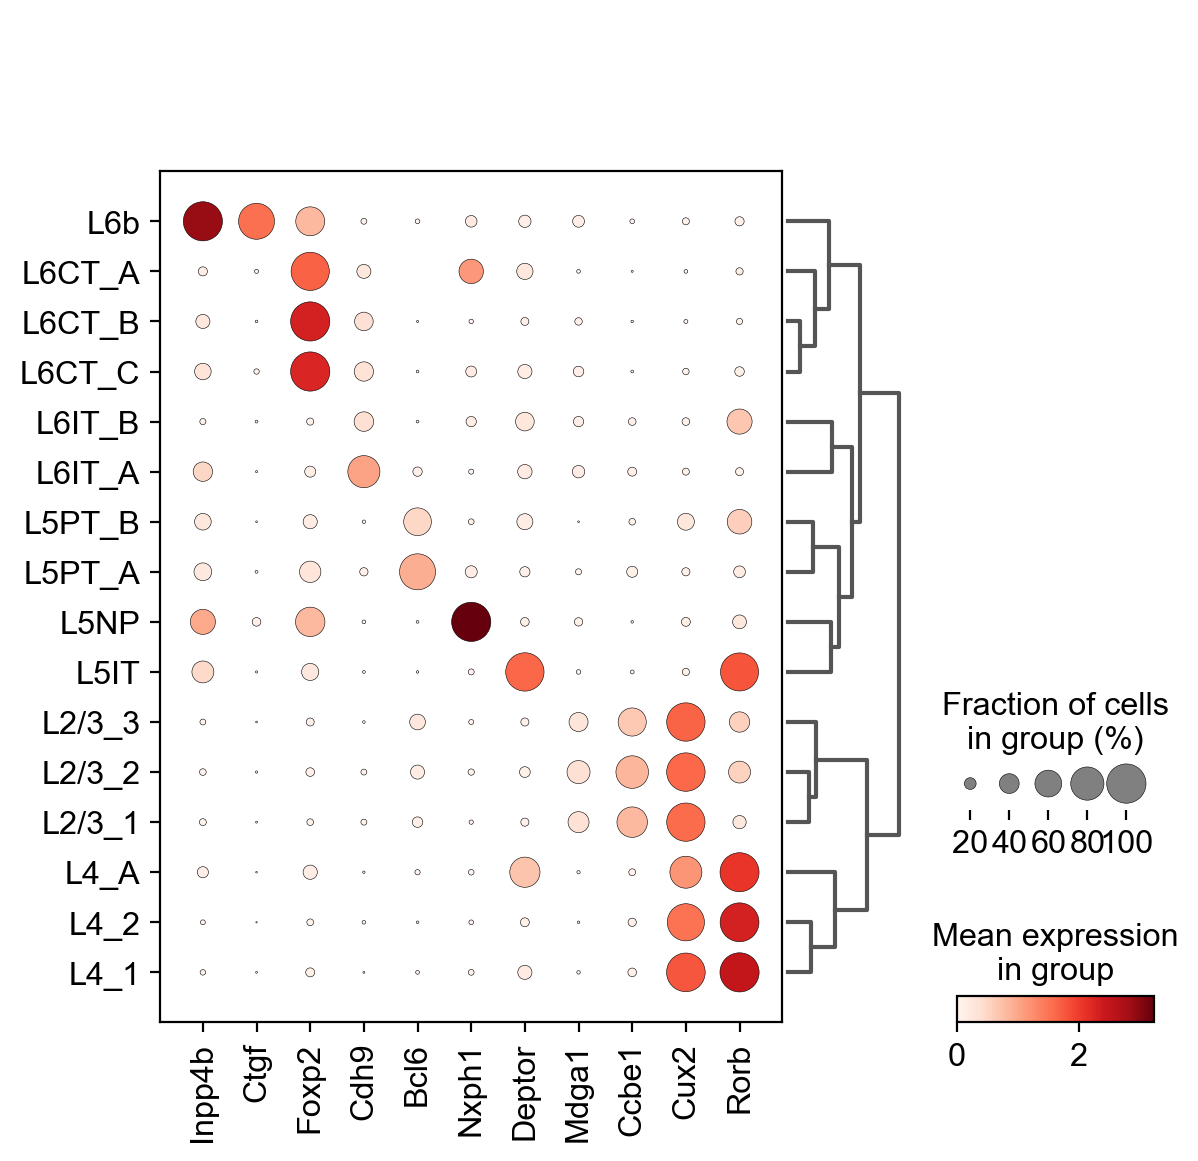

In [51]:
#sc.tl.dendrogram(P28_glut, groupby='Type', use_rep='X_harmony')

bias_markers = ['Inpp4b', 'Ctgf', 'Foxp2', 'Cdh9', 'Bcl6', 
                 'Nxph1',   'Deptor', 'Mdga1', 'Ccbe1', 'Cux2', 'Rorb',]

sc.pl.dotplot(P28_glut, bias_markers, groupby='Type', dendrogram=True)

# L4

# Write

In [8]:
#P28_glut.write_h5ad('P28_glut_dr_harmony_112420.h5ad')
#P28_glut.write_h5ad('P28_glut_dr_harmony_120120.h5ad')

P28_glut.write_h5ad('P28_glut_dr_harmony_032921.h5ad')